<a href="https://colab.research.google.com/github/tomi2077/Computer_Vision/blob/master/CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. mounting google drive  
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer_Vision/Computer_Vision_Tasks' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['model.pth', 'MNIST_A.ipynb', '.ipynb_checkpoints', 'mnist_cnn_b.pth', 'optimizer.pth', 'MNIST_B.ipynb', 'fmnist_model.pth', 'FashionMNIST.ipynb', 'FacialEmotionRecog.ipynb', 'Caltech101.ipynb', 'Caltech101.zip', 'caltech101B.ipynb', 'CIFAR_10.gz', 'CIFAR.ipynb']


In [165]:
# importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from six.moves import cPickle 

from skimage import img_as_ubyte, io, color
from collections import Counter
import tarfile
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import matplotlib.image as mpimg
import torch 
import torchvision 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms 
import torch.nn as nn
import torch.optim as optim

# setting random seed for pytorch and numpy for reproducible results
torch.manual_seed(10)
np.random.seed(0)


In [166]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
    

In [167]:
#Read Path of Data
tr_data_batch_1 = unpickle('/content/cifar-10-batches-py/data_batch_1')
tr_data_batch_2 = unpickle('/content/cifar-10-batches-py/data_batch_2')
tr_data_batch_3 = unpickle('/content/cifar-10-batches-py/data_batch_3')
tr_data_batch_4 = unpickle('/content/cifar-10-batches-py/data_batch_4')
tr_data_batch_5 = unpickle('/content/cifar-10-batches-py/data_batch_5')
test_batch = unpickle('/content/cifar-10-batches-py/test_batch')

In [220]:
#Load Train Images and label
tr_data_batch_1 = open('/content/cifar-10-batches-py/data_batch_1', 'rb')
train_datadict = cPickle.load(tr_data_batch_1,encoding='latin1')
tr_data_batch_1.close()
train_data = train_datadict["data"] 
train_label = train_datadict['labels']
train_data = train_data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
train_label = np.array(train_label)

In [219]:
#Load Test Images and label
test_batch = open('/content/cifar-10-batches-py/test_batch', 'rb')
test_datadict = cPickle.load(test_batch,encoding='latin1')
test_batch.close()
test_data = test_datadict['data']
test_label = test_datadict['labels']
test_data = test_data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
test_label = np.array(test_label)

In [221]:
labels_map = {
    0: 'airplane',
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck ",
}

In [222]:
train_labels_, train_labels_count = np.unique(train_label, return_counts=True)
test_labels_, test_labels_count = np.unique(test_label, return_counts=True)
print("Count and unique labels values in the training set: Values:{} , Counts:{}".format(train_labels_, train_labels_count))
print("Count and unique labels values in the testing set: Values:{} , Counts:{}".format(test_labels_, test_labels_count))

Count and unique labels values in the training set: Values:[0 1 2 3 4 5 6 7 8 9] , Counts:[1005  974 1032 1016  999  937 1030 1001 1025  981]
Count and unique labels values in the testing set: Values:[0 1 2 3 4 5 6 7 8 9] , Counts:[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [223]:
print(f'Images Shape: {train_data.shape}')
print(f'Labels Shape: {train_label.shape}')
print(f'Images Shape: {test_data.shape}')
print(f'Labels Shape: {test_label.shape}')
print("train_imgs min,max values: {},{} , test_imgs min,max values: {},{}".format(np.min(train_data), np.max(train_data) , np.min(test_data), np.max(test_data) ))

Images Shape: (10000, 32, 32, 3)
Labels Shape: (10000,)
Images Shape: (10000, 32, 32, 3)
Labels Shape: (10000,)
train_imgs min,max values: 0,255 , test_imgs min,max values: 0,255


In [224]:
train_data = np.array(train_data)

In [207]:
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_label)
# targets: array([0, 1, 2, 3])
train_labels_encoded, train_labels_endoded_count = np.unique(test_label, return_counts=True)
print("Count and unique labels values in the testing set: Values:{} , Counts:{}".format(train_labels_encoded, train_labels_endoded_count))

Count and unique labels values in the testing set: Values:[0 1 2 3 4 5 6 7 8 9] , Counts:[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


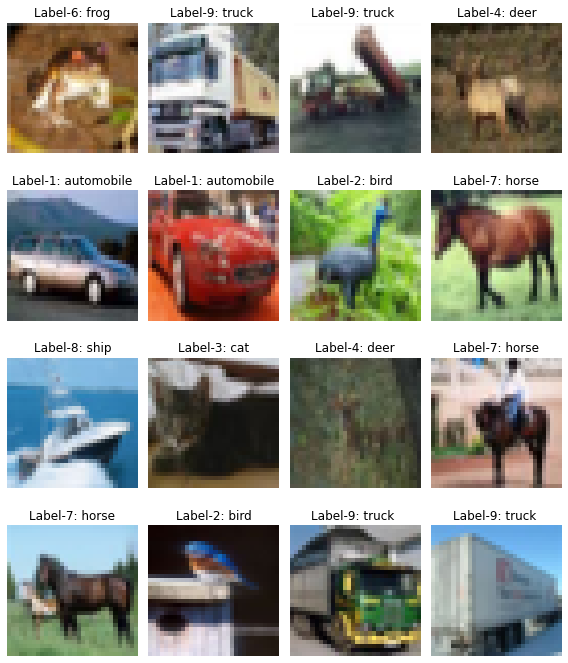

In [228]:
num_rows = 4
num_cols = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize =(8, 10), sharex=True, sharey=True)
ax = axes.ravel()

idxs = np.random.choice(len(train_data), (num_rows*num_cols,))
for i, idx in enumerate(idxs):
  ax[i].imshow(train_data[i])
  ax[i].set_title('Label-{}: {}'.format(train_label[i], labels_map[train_label[i]]))
  ax[i].set_axis_off()
  fig.tight_layout()
plt.show()

In [209]:
class createDataset(Dataset) :
  def __init__(self, imgs_arr, labels_arr):
    super(createDataset, self).__init__()
    self.imgs_arr   = imgs_arr
    self.labels_arr = labels_arr 
    
    # transforms.ToTensor() transformation converts numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    #self.transform = transforms.ToTensor() 
    self.transform = transforms.ToTensor() 

  def __getitem__(self, index):
    x = self.imgs_arr[index]
    x = self.transform(x)
    y = self.labels_arr[index]
    y = torch.tensor(y)
    return x,y

  def __len__(self):
    return len(self.labels_arr)



In [210]:
train_dataset = createDataset(train_data, train_label)
test_dataset  = createDataset(test_data, test_label)

In [249]:
# setting some hyperparameters
train_batch_size = 32
test_batch_size  = 32
learning_rate = 0.001
momentum=0.5
n_epochs = 5

In [244]:
# creating train and test set dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)

torch.Size([64, 3, 32, 32]) torch.Size([64])
tensor(0.) tensor(1.)


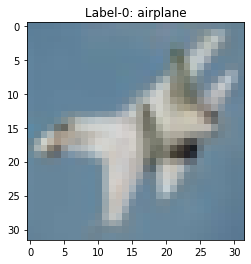

In [234]:
# visualizing a sample image from the dataset (also, for verifying correctness of the dataloader)
sample_imgs, sample_labels = next(iter(test_dataloader))
print(sample_imgs.shape, sample_labels.shape)
print(torch.min(sample_imgs), torch.max(sample_imgs))
sample_img = sample_imgs[10].permute(1,2,0) #32 x 32 x 3
sample_label = sample_labels[10]
plt.imshow(sample_img)
plt.title("Label-{}: {}".format(sample_label, labels_map[sample_label.item()]))
plt.show()

In [245]:
class cnn_model(nn.Module):
  def __init__(self, num_classes=10) :
    super(cnn_model, self).__init__()
    self.num_classes = num_classes
    self.base_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1), #32
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1), #32
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.MaxPool2d(2), # 16

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1), # 16
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.MaxPool2d(2), # 8
        nn.Dropout(0.25),

        # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1), # 37
        # nn.ReLU(inplace=True),
        # nn.BatchNorm2d(num_features= 64),
        # nn.MaxPool2d(2), # (25-2)//2 + 1 = 18
        # nn.Dropout(0.25),

        # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1), #18
        # nn.ReLU(inplace=True),
        # nn.BatchNorm2d(num_features= 64),
        # nn.MaxPool2d(2), #9*9*64
        # nn.Dropout(0.25),
        )
    
    self.classifier_layer = nn.Sequential(
        nn.Linear(in_features= 2048, out_features= 256), # updated number of out_features # 6*6*64
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(num_features= 256),  # updated number of num_features
        nn.Dropout(0.5),  
        nn.Linear( in_features= 256, out_features= self.num_classes)    # updated number of in_features
        )      
        
  def forward(self,x) :
    x = self.base_layer(x)
    x = x.reshape(x.size(0),-1)
    out = self.classifier_layer(x)
    return out


In [246]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device used is {}".format(device))
model = cnn_model()
model.to(device) # send model to device/GPU for training 

Device used is cuda


cnn_model(
  (base_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (classifier_layer): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0

In [247]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [248]:
len(train_dataloader)

313

In [263]:
# Train the model
total_step = len(train_dataloader)

for epoch in range(n_epochs):
  loss_list = []
  acc_list = []
  count =[]
  for i, (images, labels) in enumerate(train_dataloader):
    count.append(i)
    #Run the forward pass
    # images = images.cuda()
    # label = labels.cuda()
    images, labels = next(iter(train_dataloader))    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # outputs = outputs.to(device)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data,dim=1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i + 1) % 50 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, n_epochs, i + 1, total_step, loss.item(),
                      (correct / total) * 100))

Epoch [1/5], Step [50/313], Loss: 0.2096, Accuracy: 93.75%
Epoch [1/5], Step [100/313], Loss: 0.1117, Accuracy: 93.75%
Epoch [1/5], Step [150/313], Loss: 0.1443, Accuracy: 93.75%
Epoch [1/5], Step [200/313], Loss: 0.0626, Accuracy: 96.88%
Epoch [1/5], Step [250/313], Loss: 0.0105, Accuracy: 100.00%
Epoch [1/5], Step [300/313], Loss: 0.0075, Accuracy: 100.00%
Epoch [2/5], Step [50/313], Loss: 0.0048, Accuracy: 100.00%
Epoch [2/5], Step [100/313], Loss: 0.0019, Accuracy: 100.00%
Epoch [2/5], Step [150/313], Loss: 0.0085, Accuracy: 100.00%
Epoch [2/5], Step [200/313], Loss: 0.0074, Accuracy: 100.00%
Epoch [2/5], Step [250/313], Loss: 0.0526, Accuracy: 96.88%
Epoch [2/5], Step [300/313], Loss: 0.0525, Accuracy: 96.88%
Epoch [3/5], Step [50/313], Loss: 0.0013, Accuracy: 100.00%
Epoch [3/5], Step [100/313], Loss: 0.0152, Accuracy: 100.00%
Epoch [3/5], Step [150/313], Loss: 0.0185, Accuracy: 100.00%
Epoch [3/5], Step [200/313], Loss: 0.0003, Accuracy: 100.00%
Epoch [3/5], Step [250/313], Loss

In [327]:
# Test the model
model.eval()
count = 0
test_acc_list = []
test_loss_list = []
count_test = 0 
num_samples = []

with torch.no_grad():
  correct = 0
  total = 0


  for (images, labels) in test_dataloader:
    count += 1
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss_list.append(loss.item())

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    test_acc_list.append(correct / total)

    if count % 300 ==0:
      print('Test Accuracy of the model on the 10,000 test images: {:.2f} %'.format((correct / total) * 100))

# Save the model and plot





Test Accuracy of the model on the 10,000 test images: 64.11 %


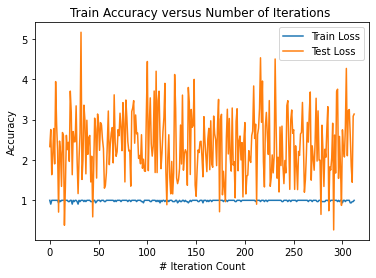

In [295]:
epochs = np.arange(n_epochs)

plt.figure()
plt.title("Train Accuracy versus Number of Iterations ")
plt.ylabel("Accuracy")
plt.xlabel("# Iteration Count")
plt.plot(count, acc_list, label='Train Loss')
plt.plot(count, test_loss_list, label='Test Loss')
plt.plot()
plt.legend()

plt.show()

In [313]:
len(test_acc_list), count

(313, 313)

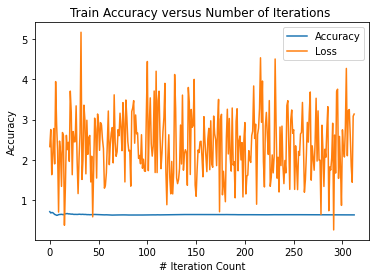

In [314]:
count_num = range(count)

plt.figure()
plt.title("Train Accuracy versus Number of Iterations ")
plt.ylabel("Accuracy")
plt.xlabel("# Iteration Count")
plt.plot(count_num, test_acc_list, label='Accuracy')
plt.plot(count_num, test_loss_list, label='Loss')
plt.plot()
plt.legend()

plt.show()

In [315]:
# defining function to get the predicted labels from the trained model 
def get_pred_label(model, img):
  img = img.copy()
  img_tensor = torch.from_numpy(img)
  img_tensor = img_tensor/255.
  img_tensor = torch.unsqueeze(img_tensor, 0)
  img_tensor = img_tensor.permute(0,3,1,2)
  img_tensor = img_tensor.to(device)
  model.eval() # set model to evaluation mode 
  output = model(img_tensor)
  _, pred_label = torch.max(output, dim=1)
  return pred_label[0].item()

In [316]:
# getting model predictions on training set
num_samples = len(train_data)
preds_train = []
for i in range(num_samples) :
  pred = get_pred_label(model, train_data[i])
  preds_train.append(pred)

In [317]:
# getting model predictions on testing set
num_samples = len(test_data)
preds_test = []
for i in range(num_samples) :
  pred = get_pred_label(model, test_data[i])
  preds_test.append(pred)

In [318]:
# printing accuracy scores 
acc_train = accuracy_score(train_label, preds_train)
acc_test  = accuracy_score(test_label, preds_test)
print("Train accuracy: {}, Test accuracy: {}".format(acc_train, acc_test))

Train accuracy: 0.9902, Test accuracy: 0.6396


In [319]:
# printing confusion matrix for the test set
print("Confusion matrix ")
confusion_matrix(test_label, preds_test)

Confusion matrix 


array([[675,  15,  93,  27,  25,   7,   2,  18, 105,  33],
       [ 21, 730,  14,  21,   6,   7,   3,  11,  52, 135],
       [ 84,   6, 464,  83, 118, 105,  41,  55,  34,  10],
       [ 41,   7,  69, 474,  69, 185,  55,  54,  23,  23],
       [ 19,   4,  71, 111, 557,  52,  37, 131,   9,   9],
       [ 17,   2,  59, 181,  64, 557,  27,  73,  10,  10],
       [ 16,  14,  47, 126,  52,  50, 639,  33,  10,  13],
       [ 15,   2,  28,  55,  49,  75,   8, 735,   7,  26],
       [ 76,  30,  17,  18,   8,  11,   7,   5, 791,  37],
       [ 34,  80,   7,  22,   6,  12,   5,  29,  31, 774]])

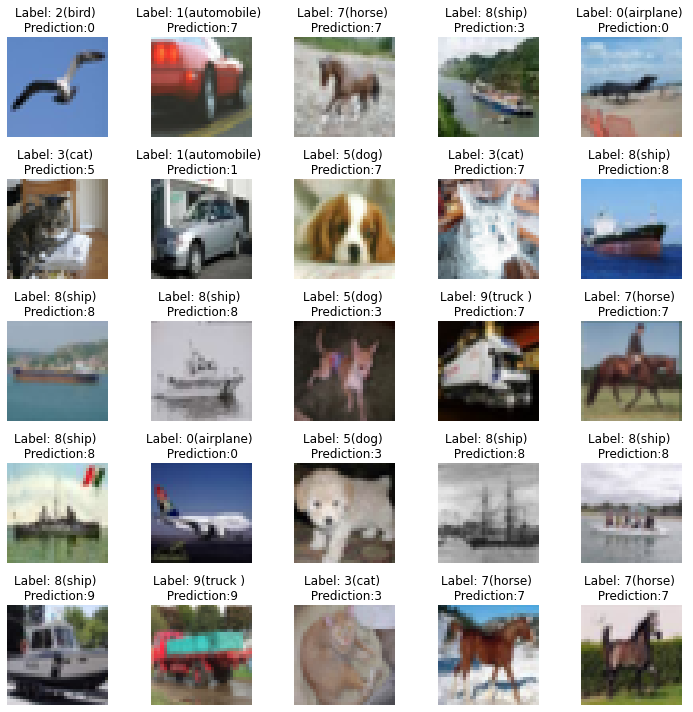

In [322]:
# visualizing the predictions 

num_rows = 5
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

idxs = np.random.choice( len(train_data), (num_rows*num_cols,) )
for i, idx in enumerate(idxs):
  ax[i].imshow(test_data[idx])
  ax[i].set_title('Label: {}({}) \n Prediction:{}'.format(test_label[idx], labels_map[test_label[idx]], preds_test[idx]))
  ax[i].set_axis_off()
fig.tight_layout()
plt.show()
